# Traffic Sign Detection - Faster RCNN Pytorch

In [ ]:
! pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 11.5MB/s 
     |████████████████████████████████| 952kB 19.4MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=cf887ea5a79434de1ad383bfa63f3fdef0a1c5a97566fce0c68abd7c0956c40b
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import pandas as pd
import json
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = '/content/drive/My Drive/Colab Notebooks/za_traffic_2020/traffic_train'
DIR_TRAIN = f'{DIR_INPUT}/images'
DIR_TEST = f'/content/drive/My Drive/Colab Notebooks/za_traffic_2020/traffic_public_test/images'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open(f"{DIR_INPUT}/train_traffic_sign_dataset.json", "r") as fin:
    data = json.load(fin)

labels = []
bboxes = []
images_id = []
for i in range(len(data['annotations'])):
    labels.append(data['annotations'][i]['category_id'])
    bboxes.append(data['annotations'][i]['bbox'])
    images_id.append(data['annotations'][i]['image_id'])

train_df = pd.DataFrame()
train_df['labels'] = labels
train_df['bbox'] = bboxes
train_df['image_id'] = images_id
train_df.head()

,labels,bbox,image_id
0,2,"[880, 333, 19, 18]",3
1,3,"[1069, 355, 83, 83]",5
2,2,"[768, 480, 9, 7]",5
3,6,"[781, 337, 17, 15]",6
4,2,"[733, 352, 7, 8]",16


In [ ]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'])
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)
train_df.head()

,labels,image_id,x,y,w,h
0,2,3,880.0,333.0,19.0,18.0
1,3,5,1069.0,355.0,83.0,83.0
2,2,5,768.0,480.0,9.0,7.0
3,6,6,781.0,337.0,17.0,15.0
4,2,16,733.0,352.0,7.0,8.0


In [ ]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-900:]
train_ids = image_ids[:-900]

In [ ]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [ ]:
valid_df.shape, train_df.shape

((2591, 6), (8409, 6))

In [ ]:
train_df.head()

,labels,image_id,x,y,w,h
0,2,3,880.0,333.0,19.0,18.0
1,3,5,1069.0,355.0,83.0,83.0
2,2,5,768.0,480.0,9.0,7.0
3,6,6,781.0,337.0,17.0,15.0
4,2,16,733.0,352.0,7.0,8.0


In [ ]:
class TraficDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.png', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:

def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


# Create the model

In [ ]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
num_classes = 2  # include: background and traffic sign

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = TraficDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = TraficDataset(valid_df, DIR_TRAIN, get_valid_transform())

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Sample

In [ ]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [ ]:
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


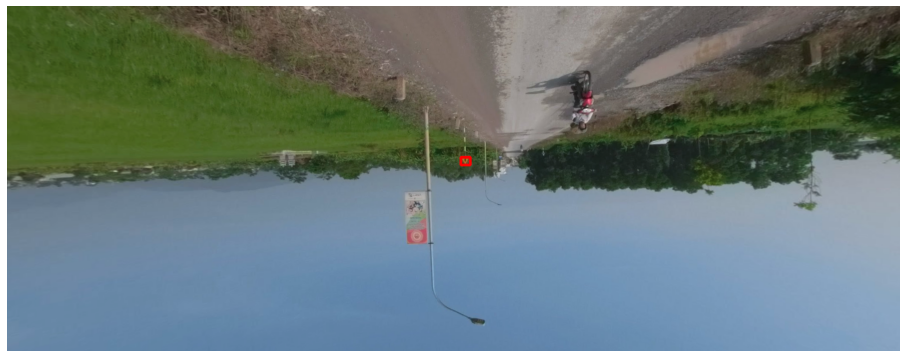

In [ ]:
# plot demo training set
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

# Train

In [ ]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 1

In [ ]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

In [ ]:
# Test on valid set
images, targets, image_ids = next(iter(valid_data_loader))

In [ ]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [ ]:
boxes_truth = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()

In [ ]:
# Prediction
model.eval()
cpu_device = torch.device("cpu")

outputs = model([images[0]])
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

bboxes = outputs[0]['boxes'][outputs[0]["scores"] > 0.5]
labels = outputs[0]['labels'][outputs[0]["scores"] > 0.5]
scores = outputs[0]['scores'][outputs[0]["scores"] > 0.5]

tensor([[821.8936, 332.8680, 841.1544, 352.4200]], grad_fn=<IndexBackward>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


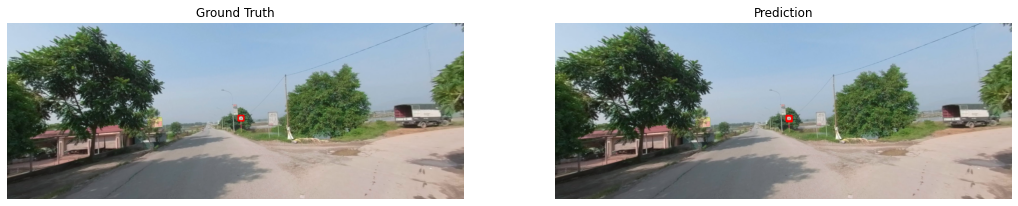

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 9))
# plot ground truth
for box in boxes_truth:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
ax[0].set_title("Ground Truth")
ax[0].set_axis_off()
ax[0].imshow(sample)

# plot prediction
for box in bboxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
ax[1].set_title("Prediction")
ax[1].set_axis_off()
ax[1].imshow(sample)

# TEST

In [ ]:
from torch.autograd import Variable
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
# load image
image_test = plt.imread("/content/drive/My Drive/Colab Notebooks/za_traffic_2020/traffic_public_test/images/10013.png")
# transform image to tensor
transform = transforms.Compose([transforms.ToTensor(),])
image_test_tensor = transform(image_test).to(device)
image_test_tensor

tensor([[[0.3333, 0.3333, 0.3333,  ..., 0.7255, 0.7255, 0.7255],
         [0.3333, 0.3333, 0.3333,  ..., 0.7294, 0.7255, 0.7255],
         [0.3333, 0.3333, 0.3333,  ..., 0.7216, 0.7255, 0.7255],
         ...,
         [0.5294, 0.5294, 0.5294,  ..., 0.4941, 0.4941, 0.4941],
         [0.5333, 0.5333, 0.5294,  ..., 0.4941, 0.4941, 0.4941],
         [0.5333, 0.5333, 0.5294,  ..., 0.4941, 0.4941, 0.4941]],

        [[0.4235, 0.4235, 0.4235,  ..., 0.8078, 0.8078, 0.8078],
         [0.4235, 0.4235, 0.4235,  ..., 0.8039, 0.8078, 0.8078],
         [0.4235, 0.4235, 0.4235,  ..., 0.8039, 0.8078, 0.8078],
         ...,
         [0.4627, 0.4627, 0.4627,  ..., 0.4235, 0.4235, 0.4235],
         [0.4627, 0.4588, 0.4588,  ..., 0.4235, 0.4235, 0.4235],
         [0.4627, 0.4588, 0.4627,  ..., 0.4235, 0.4235, 0.4235]],

        [[0.5451, 0.5451, 0.5451,  ..., 0.8902, 0.8941, 0.8941],
         [0.5451, 0.5451, 0.5451,  ..., 0.8863, 0.8941, 0.8941],
         [0.5451, 0.5451, 0.5451,  ..., 0.8863, 0.8902, 0.

In [ ]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model([image_test_tensor])
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

bboxes = outputs[0]['boxes'][outputs[0]["scores"] > 0.5]
labels = outputs[0]['labels'][outputs[0]["scores"] > 0.5]
scores = outputs[0]['scores'][outputs[0]["scores"] > 0.5]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


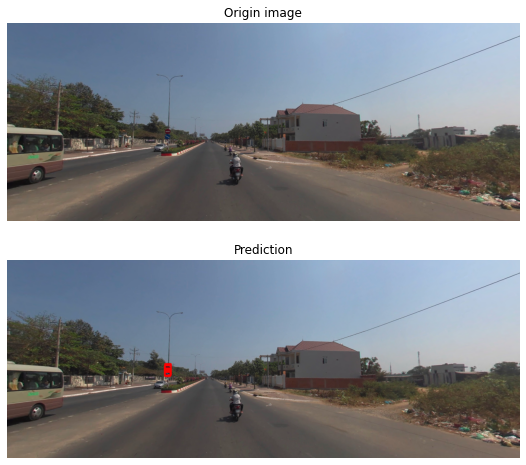

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8))

# plot origin image
ax[0].set_title("Origin image")
ax[0].set_axis_off()
ax[0].imshow(image_test)

# plot prediction
for box in bboxes:
    cv2.rectangle(image_test,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
ax[1].set_title("Prediction")    
ax[1].set_axis_off()
ax[1].imshow(image_test)



# Save model

In [ ]:
torch.save(model, "traffic_sign_detection.pt")